In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df_monthly = pd.read_csv('Assignment-monthlyexcerpt.csv')
df_daily = pd.read_csv('Assignment-dailyexcerpt.csv')

In [5]:
df_monthly.drop(['Unnamed: 2','Unnamed: 5','Unnamed: 8','Unnamed: 11','Unnamed: 14','Unnamed: 17','Unnamed: 20'],axis=1,inplace=True)

In [6]:
for i in range(0,df_monthly.columns.shape[0],2):
    
    df_ = df_monthly.iloc[:,i:i+2].dropna()
    
    df_ = df_.drop(0)
    df_.columns = ['date',df_.columns[1]]
    df_.date = pd.to_datetime(df_.date)
    df_.iloc[:,0] = pd.to_numeric(df_.iloc[:,0])
    df_ = df_.set_index('date')
    df_.to_csv('clean_data/{}_monthly.csv'.format(df_.columns[0].lower().replace(' ','_').replace('/','_')))

In [7]:
df_monthly = df_monthly.drop(df_monthly.columns[0:-1:2][1:],axis=1)

In [8]:
df_monthly.drop(0,inplace=True)
df_monthly.dropna(inplace=True)

In [9]:
df_monthly.rename(columns={'BO1 Comdty':'date'},inplace=True)

In [10]:
for column in df_monthly.columns[1:]:
    
    df_monthly.loc[:,column] = pd.to_numeric(df_monthly.loc[:,column])
    
    df_monthly.rename(columns={column:column.lower().replace(' ','_').replace('/','_')},inplace=True)

In [11]:
df_monthly.date = pd.to_datetime(df_monthly.date)

In [12]:
df_monthly.date = df_monthly.date.map(lambda x:'{}-{}-01'.format(x.year,x.month))

df_monthly.date = pd.to_datetime(df_monthly.date)

df_monthly = df_monthly.set_index('date').asfreq('MS')

## Analysis

In [15]:
df_monthly.columns

Index(['cbot_soybean_oil_future', 'ice_brent_crude_oil_future',
       'ice_gas_oil_future', 'crude_palm_oil_fob_spot',
       'us_dollar_malaysian_ringgit', 'noaa_oceanic_nino_index_oni',
       'total_palm_oil_inventory_data', 'dollar_index_spot'],
      dtype='object')

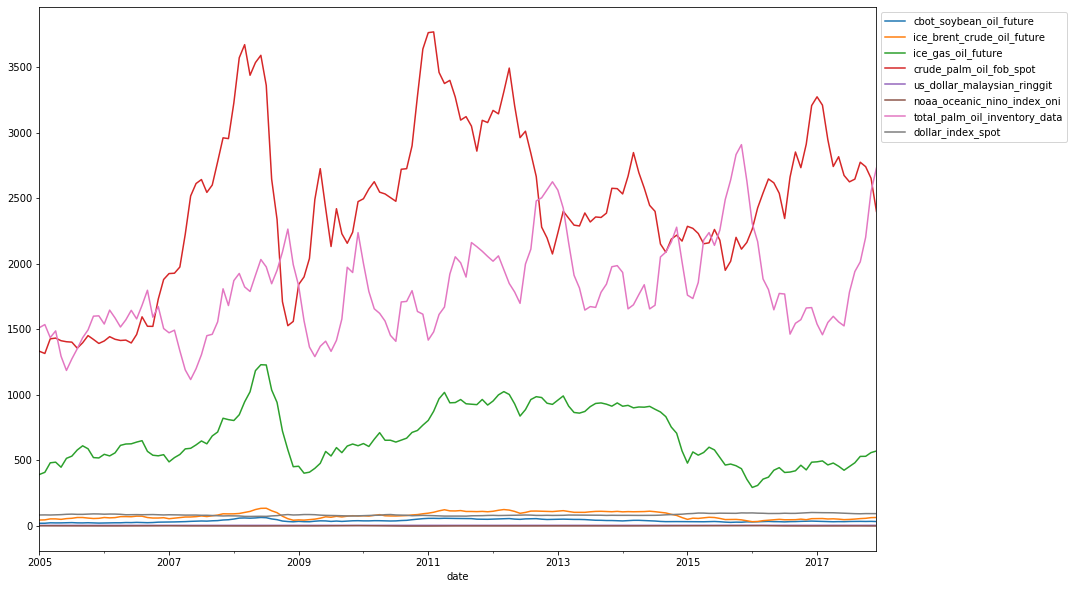

In [16]:
fig,ax = plt.subplots(figsize=(15,10))
df_monthly.plot(ax=ax)
plt.legend(bbox_to_anchor=(1,1))

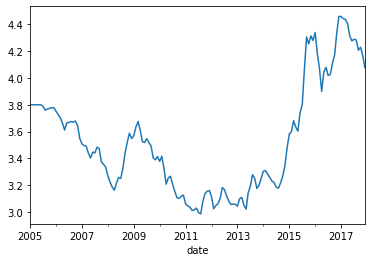

In [17]:
df_monthly.us_dollar_malaysian_ringgit.plot()

[]

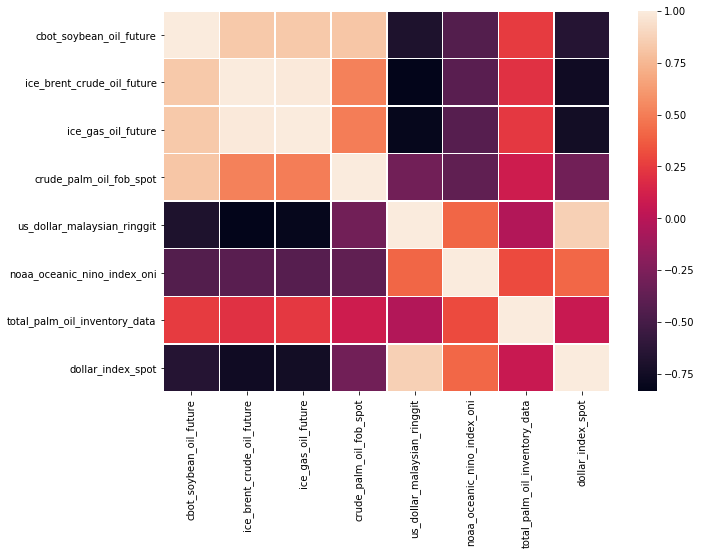

In [18]:
# Correlation between features
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_monthly.corr(),linewidths=.5).plot(ax=ax)


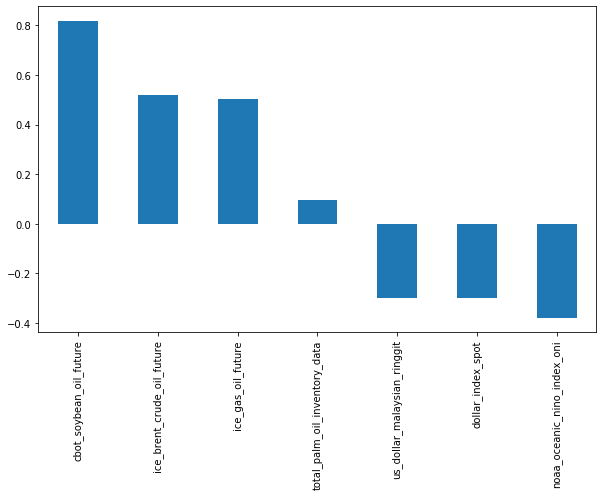

In [19]:
## Correlation other features with palm oil
fig, ax = plt.subplots(figsize=(10,6))
df_monthly.corr().loc['crude_palm_oil_fob_spot'].drop('crude_palm_oil_fob_spot').sort_values(ascending=False).plot(kind='bar',ax=ax)

### Prediction

In [20]:
## Data split train,validate,test for model evaluation

df_train = df_monthly.loc[pd.date_range('2005-01-01','2015-12-01',freq='MS')]
df_validate = df_monthly.loc[pd.date_range('2016-01-01','2016-12-01',freq='MS')]
df_test = df_monthly.loc[pd.date_range('2017-01-01','2017-12-01',freq='MS')]

## Univariate Model

We start with univariate model first for this time series prediction before moving to multivariate model.

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition
from statsmodels.tsa.stattools import adfuller,pacf,acf

In [22]:
X_y_train = df_train.loc[:,'crude_palm_oil_fob_spot']
X_y_validate = df_validate.loc[:,'crude_palm_oil_fob_spot']
X_y_test = df_test.loc[:,'crude_palm_oil_fob_spot']

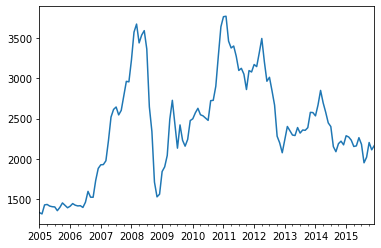

In [23]:
X_y_train.plot()

In [24]:
## Yearly composition
sd = seasonal_decompose(X_y_train, model='additive', period=12)

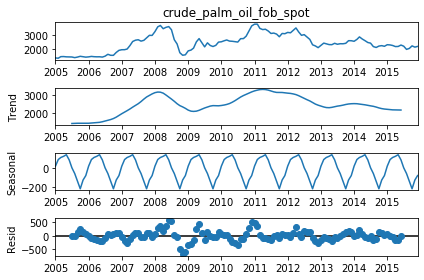

In [25]:
sd.plot()
plt.show()

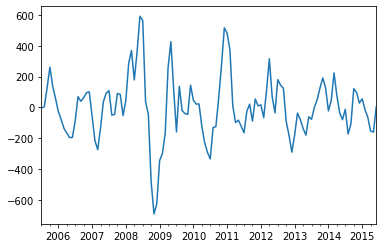

In [26]:
sd.resid.dropna().plot()

In [27]:
sd.resid.dropna().mean()

1.4498263888890472

In [28]:
sd = seasonal_decompose(X_y_train, model='additive', period=4)

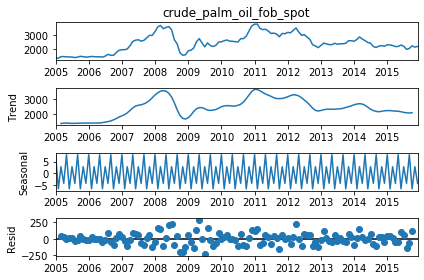

In [29]:
sd.plot()
plt.show()

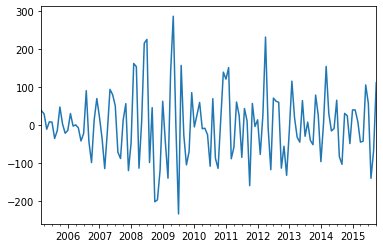

In [30]:
sd.resid.dropna().plot()

In [31]:
sd.resid.dropna().mean()

0.5495019531250115

We will use the period of quarterly since the average residual is much more lower compare to 12 month cycle .

## Check the stationarity of the data

In [32]:
def plot_acf(ts):
    
    acf_value = acf(ts)
    
    plt.bar(np.arange(1,acf_value.shape[0]+1),acf_value)
    plt.xlabel('Lags')

def plot_pacf(ts):
    
    pacf_value = pacf(ts)

    plt.bar(np.arange(1,pacf_value.shape[0]+1),pacf_value)
    plt.xlabel('Lags')

In [33]:
def check_stationarity(ts):
    
    test_value = adfuller(ts)
    
    if test_value[0] < test_value[4]['1%']:
        
        return 'Stationary with 99% confidence'
    
    elif test_value[0] < test_value[4]['5%']:
        
        return 'Stationary with 95% confidence'
    
    elif test_value[0] < test_value[4]['10%']:
        
        return 'Stationary with 90% confidence'
    
    else:
        
        return 'It is not Stationary'

In [34]:
check_stationarity(X_y_train)

'It is not Stationary'

In [35]:
## Try simple applying natural log
check_stationarity(np.log(X_y_train))

'It is not Stationary'

In [36]:
check_stationarity(X_y_train.diff().dropna()) ## Need 1 differece

'Stationary with 99% confidence'

In [37]:
ts_diff = X_y_train.diff().dropna()

C:\Users\A1857\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


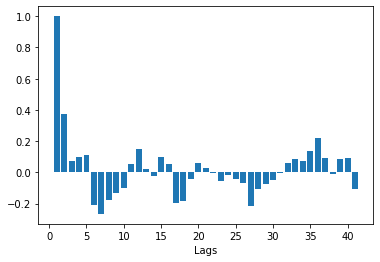

In [38]:
plot_acf(ts_diff)

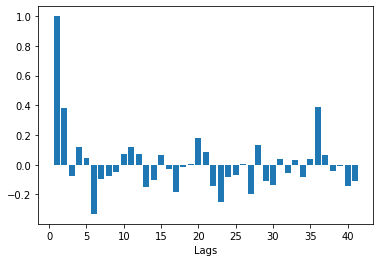

In [39]:
plot_pacf(ts_diff)

We will try ARIMA(1,1,1) based on pacf and acf plot.

## Prediction

In [40]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [41]:
forecast_period=3

In [42]:
def mean_absolute_percentage_error(actual,forecast):
    
    return np.mean(np.abs((actual-forecast)/actual))

In [43]:
def naive_forecast(ts,forecast_period=3):
    
    return np.repeat(ts[-1],forecast_period)

In [44]:
def arima_forecast(ts,arima_order,forecast_period=3):
    
    arima = ARIMA(ts,order=arima_order)
    arima_results = arima.fit()
    
    return arima_results.forecast(forecast_period)[0]

In [45]:
def sarimax_foreacst(ts,sarimax_order=(1,1,1,4),forecast_period=3):
    
    sarimax = SARIMAX(ts, seasonal_order=(1,1,1,4))
    sarimax_results = sarimax.fit()

    return sarimax_results.forecast(forecast_period)

In [46]:
def linear_forecast(ts,n_lag=3,forecast_period=3):
    
    y = ts.tail(n_lag).values
    X = np.arange(y.shape[0])
    lr = LinearRegression()
    lr.fit(X.reshape(-1,1),y)
    
    
    predict = lr.predict(np.arange(X[-1],X[-1]+forecast_period).reshape(-1,1))
    
    return predict

In [47]:
### Test

# arima_forecast_result = arima_forecast(X_y_train,(1,1,1))
# naive_forecast_result = naive_forecast(X_y_train)

In [48]:
ts_validate = pd.DataFrame(index=np.arange(10),columns=['date_range','actual_value'])


for i in range(10):
    
    ts_validate.iloc[i,0] = list(map(lambda x:str(x.date()),X_y_validate.index[i:i+3]))
    ts_validate.iloc[i,1] = X_y_validate.values[i:i+3]

### Evaluate over the period of our validation sets 2016 (with a sliding of 3 Months)

In [49]:
ts_train = X_y_train.copy()
ts_validate_performance = ts_validate.copy()

In [50]:
ts_validate_performance['arima_error'] = np.nan
ts_validate_performance['naive_error'] = np.nan
ts_validate_performance['sarimax_error'] = np.nan
ts_validate_performance['linear_error'] = np.nan

In [51]:
for i in range(ts_validate_performance.shape[0]):

#     print(ts_validate_performance.loc[i,'date_range'])

    arima_forecast_result = arima_forecast(ts_train,(1,1,1))
#     print('ARIMA Forecast: {}'.format(arima_forecast_result))
    sarimax_forecast_result = sarimax_foreacst(ts_train,(1,1,1,3))
#     print('SARIMAX Forecast: {}'.format(arima_forecast_result))
    naive_forecast_result = naive_forecast(ts_train)
#     print('Naive Forecast: {}'.format(naive_forecast_result))
    linear_forecast_result = linear_forecast(ts_train)
    


    arima_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],arima_forecast_result)
    sarimax_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],sarimax_forecast_result)
    naive_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],naive_forecast_result)
    linear_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],linear_forecast_result)



    ts_validate_performance.loc[i,'arima_error'] = arima_error
    ts_validate_performance.loc[i,'sarimax_error'] = sarimax_error
    ts_validate_performance.loc[i,'naive_error'] = naive_error
    ts_validate_performance.loc[i,'linear_error'] = linear_error

    ts_train = ts_train.append(X_y_validate.iloc[:i])

In [52]:
ts_validate_performance.loc[:,['arima_error','naive_error','sarimax_error','linear_error']].mean()

arima_error      0.087324
naive_error      0.095361
sarimax_error    0.085205
linear_error     0.110056
dtype: float64

In [53]:
ts_validate_performance

,date_range,actual_value,arima_error,naive_error,sarimax_error,linear_error
0,"[2016-01-01, 2016-02-01, 2016-03-01]","[2266.03, 2427.82, 2541.84]",0.080256,0.100564,0.049955,0.118080
1,"[2016-02-01, 2016-03-01, 2016-04-01]","[2427.82, 2541.84, 2648.98]",0.127288,0.146593,0.098379,0.163284
2,"[2016-03-01, 2016-04-01, 2016-05-01]","[2541.84, 2648.98, 2619.25]",0.110916,0.129309,0.102749,0.103408
3,"[2016-04-01, 2016-05-01, 2016-06-01]","[2648.98, 2619.25, 2539.5]",0.032091,0.066851,0.069172,0.051759
4,"[2016-05-01, 2016-06-01, 2016-07-01]","[2619.25, 2539.5, 2347.03]",0.047316,0.037826,0.057129,0.096262
5,"[2016-06-01, 2016-07-01, 2016-08-01]","[2539.5, 2347.03, 2663.07]",0.076345,0.059018,0.063982,0.099335
6,"[2016-07-01, 2016-08-01, 2016-09-01]","[2347.03, 2663.07, 2854.63]",0.070052,0.071632,0.064060,0.059899
7,"[2016-08-01, 2016-09-01, 2016-10-01]","[2663.07, 2854.63, 2735.03]",0.079206,0.076095,0.076932,0.092797
8,"[2016-09-01, 2016-10-01, 2016-11-01]","[2854.63, 2735.03, 2914.48]",0.187979,0.171460,0.165552,0.212551
9,"[2016-10-01, 2016-11-01, 2016-12-01]","[2735.03, 2914.48, 3209.35]",0.061789,0.094263,0.104140,0.103187


In [54]:
## Lets try to include seasonal 

### Multivariate Forecast

The idea in multivariate forecast is we will try to predict the features and from the features we will predict the palm oil prices.

1. Reduce the dimension of the features using PCA to 2 or 1 components (information will be loss)
2. Forecast the features for 3 months 
3. Predict the palm oil price based on forecasted feautres.

The draw back in predicting time series data by using multivariate method is there are many overhead error in predicting. For example if we reduce the dimension some information will be loss. By forecasting the features to the future there will be another error. Finally to predict the palm oil using the forecasted features will be another error. 

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [137]:
df_train_multivar_X_y = df_train.iloc[5:,:].append(df_validate) ## Remove some sample during RM peg at Rm 3.8

In [138]:
df_train_multivar_X = df_train_multivar_X_y.drop('crude_palm_oil_fob_spot',axis=1) 
df_train_multivar_y = df_train_multivar_X_y.loc[:,'crude_palm_oil_fob_spot']

In [139]:
scalar = StandardScaler()
scalar.fit(df_train_multivar_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [140]:
df_train_multivar_X.iloc[:] = scalar.transform(df_train_multivar_X)

In [141]:
lasso = Lasso(alpha=0.1) ## L1 regularizer will penalize features that are irrlevent
lasso.fit(df_train_multivar_X,df_train_multivar_y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<BarContainer object of 7 artists>

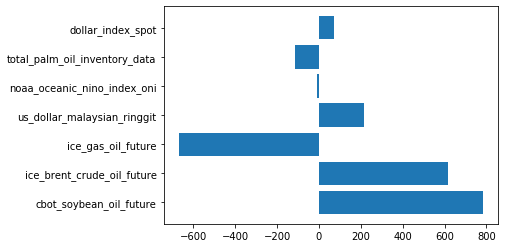

In [142]:
plt.barh(df_train_multivar_X.columns,lasso.coef_)

In [143]:
df_train_multivar_X.columns

Index(['cbot_soybean_oil_future', 'ice_brent_crude_oil_future',
       'ice_gas_oil_future', 'us_dollar_malaysian_ringgit',
       'noaa_oceanic_nino_index_oni', 'total_palm_oil_inventory_data',
       'dollar_index_spot'],
      dtype='object')

As expected __cbot_soybean_oil_future__ and __ice_brent_crude_oil_future__ will impact the palm oil *positively* and __ice_gas_oil_future__ will impact the oil price *negatively*.

In [144]:
pca = PCA(n_components=df_train_multivar_X.shape[1])

In [145]:
pca.fit(df_train_multivar_X)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'information gain (%)')

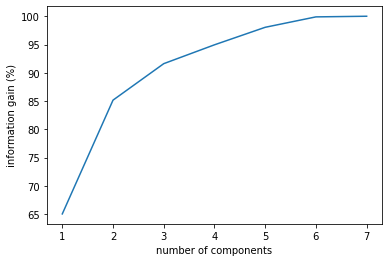

In [146]:
plt.plot(np.arange(1,pca.explained_variance_ratio_.shape[0]+1),np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('number of components')
plt.ylabel('information gain (%)')

In [173]:
pca_1_components_X = pd.DataFrame(PCA(n_components=1).fit_transform(df_train_multivar_X).ravel(),index=df_train_multivar_X.index)

In [209]:
df_train_multivar_X_pca = pca_1_components_X.iloc[:-12,]
df_train_multivar_y_pca = df_train_multivar_y.iloc[:-12]

df_train_multivar_X_pca.rename(columns={0:'component_0'},inplace=True)

In [210]:
df_val_multivar_X_pca = pca_1_components_X.iloc[-12:]
df_val_multivar_y_pca = df_train_multivar_y.iloc[-12:]

df_val_multivar_X_pca.rename(columns={0:'component_0'},inplace=True)
df_val_multivar_X_pca = df_val_multivar_X_pca.iloc[:,0]

In [211]:
X_train,X_test,y_train,y_test = train_test_split(df_train_multivar_X_pca,df_train_multivar_y_pca,test_size=0.2,random_state=0)


In [229]:
pipe = Pipeline([("Regressor", Lasso())])
# Hyperparameter grid search 
grid_param = [

                {"Regressor": [Lasso()],
                 "Regressor__alpha": [0.1,1,10,100,1000],
                 "Regressor__max_iter": [1000,2000,3000,4000]
                 },
                {"Regressor": [RandomForestRegressor(random_state=0)],
                 "Regressor__n_estimators": [10,50, 100,200]
                },
                {"Regressor": [xgb.XGBRegressor(objective ='reg:squarederror')],
                 "Regressor__n_estimators": [10,50, 100,200],
                 "Regressor__learning_rate":[0.01,0.1]
                }]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train.values,y_train)
    

In [258]:
pipe = Pipeline([("Regressor", Lasso())])
# Hyperparameter grid search 
grid_param = [

                {"Regressor": [Lasso()],
                 "Regressor__alpha": [0.1,1,10,100,1000],
                 "Regressor__max_iter": [1000,2000,3000,4000]
                 }]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)
    

In [261]:
mean_absolute_percentage_error(best_model.predict(X_test.values),y_test)

0.1685085666235359

In [232]:
## Time Series forecasting on the Features

In [233]:
df_train_multivar_X_pca.rename(columns={0:'component_1'},inplace=True)

2005-06-01    2.242219
2005-07-01    2.121632
2005-08-01    1.850808
2005-09-01    1.802452
2005-10-01    1.915647
                ...   
2015-08-01    3.458241
2015-09-01    3.838834
2015-10-01    3.795897
2015-11-01    4.209739
2015-12-01    4.361787
Length: 127, dtype: float64

In [240]:
df_train_multivar_X_pca = df_train_multivar_X_pca.iloc[:,0]

In [236]:
check_stationarity(df_train_multivar_X_pca)

'It is not Stationary'

In [237]:
check_stationarity(df_train_multivar_X_pca.diff().dropna())

'Stationary with 99% confidence'

In [255]:
def predict_time_series_multi_var(ts_train):
    
    ts_validate_performance = ts_validate.copy()
        
    ts_validate_performance['arima_error'] = np.nan
    ts_validate_performance['naive_error'] = np.nan
    ts_validate_performance['sarimax_error'] = np.nan
    ts_validate_performance['linear_error'] = np.nan

    for i in range(ts_validate_performance.shape[0]):
        
        print(i)

        try:
            arima_forecast_result = best_model.predict(np.array(arima_forecast(ts_train,(1,1,1))).reshape(-1,1))
        except:
            print('error ARIMA')
            pass
        try:
            sarimax_forecast_result = best_model.predict(np.array(sarimax_foreacst(ts_train,(1,1,1,3))).reshape(-1,1))
        except:
            print('error SARIMAX')
            pass
        try:
            naive_forecast_result = best_model.predict(np.array(naive_forecast(ts_train)).reshape(-1,1))
        except:
            print('error NAIVE')
            pass
        try:
            linear_forecast_result = best_model.predict(np.array(linear_forecast(ts_train)).reshape(-1,1))
        except:
            print('error Linear')
            pass


        try:
            arima_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],arima_forecast_result)
        except:
            arima_error = np.nan
        try:
            sarimax_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],sarimax_forecast_result)
        except:
            sarimax_error = np.nan
        try:
            naive_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],naive_forecast_result)
        except:
            naive_error = np.nan
        try:
            linear_error = mean_absolute_percentage_error(ts_validate_performance.loc[i,'actual_value'],linear_forecast_result)
        except:
            linear_error = np.nan



        ts_validate_performance.loc[i,'arima_error'] = arima_error
        ts_validate_performance.loc[i,'sarimax_error'] = sarimax_error
        ts_validate_performance.loc[i,'naive_error'] = naive_error
        ts_validate_performance.loc[i,'linear_error'] = linear_error

        ts_train = ts_train.append(df_val_multivar_X_pca.iloc[:i])
    
    return ts_validate_performance

In [257]:
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('Regressor',
                 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=1, gamma=0,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=50, n_jobs=0, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method=None,
                              validate_parameters=False, verbosity=None))],
         verbose=False)

In [256]:
predict_time_series_multi_var(df_train_multivar_X_pca)

0
1
2
3
4
error SARIMAX
5
6
7
8
9


,date_range,actual_value,arima_error,naive_error,sarimax_error,linear_error
0,"[2016-01-01, 2016-02-01, 2016-03-01]","[2266.03, 2427.82, 2541.84]",0.145455,0.145455,0.145455,0.145455
1,"[2016-02-01, 2016-03-01, 2016-04-01]","[2427.82, 2541.84, 2648.98]",0.189188,0.189188,0.189188,0.189188
2,"[2016-03-01, 2016-04-01, 2016-05-01]","[2541.84, 2648.98, 2619.25]",0.209823,0.209823,0.209823,0.209823
3,"[2016-04-01, 2016-05-01, 2016-06-01]","[2648.98, 2619.25, 2539.5]",0.209575,0.209575,0.209575,0.209575
4,"[2016-05-01, 2016-06-01, 2016-07-01]","[2619.25, 2539.5, 2347.03]",0.176283,0.176283,0.176283,0.175092
5,"[2016-06-01, 2016-07-01, 2016-08-01]","[2539.5, 2347.03, 2663.07]",0.177250,0.177250,0.179540,0.195535
6,"[2016-07-01, 2016-08-01, 2016-09-01]","[2347.03, 2663.07, 2854.63]",0.207170,0.207170,0.207170,0.222405
7,"[2016-08-01, 2016-09-01, 2016-10-01]","[2663.07, 2854.63, 2735.03]",0.248773,0.248773,0.248773,0.248773
8,"[2016-09-01, 2016-10-01, 2016-11-01]","[2854.63, 2735.03, 2914.48]",0.271068,0.271068,0.271068,0.271068
9,"[2016-10-01, 2016-11-01, 2016-12-01]","[2735.03, 2914.48, 3209.35]",0.297717,0.297717,0.297717,0.297717


In [260]:
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('Regressor',
                 Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

In [262]:
predict_time_series_multi_var(df_train_multivar_X_pca)

0
1
2
3
4
error SARIMAX
5
6
7
8
9


,date_range,actual_value,arima_error,naive_error,sarimax_error,linear_error
0,"[2016-01-01, 2016-02-01, 2016-03-01]","[2266.03, 2427.82, 2541.84]",0.471009,0.455119,0.462967,0.487498
1,"[2016-02-01, 2016-03-01, 2016-04-01]","[2427.82, 2541.84, 2648.98]",0.498132,0.483004,0.490464,0.513983
2,"[2016-03-01, 2016-04-01, 2016-05-01]","[2541.84, 2648.98, 2619.25]",0.564865,0.533916,0.536330,0.555851
3,"[2016-04-01, 2016-05-01, 2016-06-01]","[2648.98, 2619.25, 2539.5]",0.455867,0.487616,0.493420,0.471906
4,"[2016-05-01, 2016-06-01, 2016-07-01]","[2619.25, 2539.5, 2347.03]",0.369581,0.410638,0.472162,0.358200
5,"[2016-06-01, 2016-07-01, 2016-08-01]","[2539.5, 2347.03, 2663.07]",0.303304,0.348487,0.355125,0.290924
6,"[2016-07-01, 2016-08-01, 2016-09-01]","[2347.03, 2663.07, 2854.63]",0.353333,0.365871,0.339573,0.324136
7,"[2016-08-01, 2016-09-01, 2016-10-01]","[2663.07, 2854.63, 2735.03]",0.377809,0.382669,0.362578,0.373293
8,"[2016-09-01, 2016-10-01, 2016-11-01]","[2854.63, 2735.03, 2914.48]",0.416363,0.412942,0.397371,0.406280
9,"[2016-10-01, 2016-11-01, 2016-12-01]","[2735.03, 2914.48, 3209.35]",0.413921,0.417116,0.412420,0.419182


## Conclusion

From this exercise, we can conclude that the univariate model is outperforming the multivariate model in term of accuracy with a much lesser error. So, for the production we will use the __SARIMAX model with parameter of (1,1,1,3)__ as our prediction model to do the forecasting for the next 3 months.